In [1]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

import os
import re
import codecs
import csv
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Ref: https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = str(text).lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [3]:
BASE_DIR = './'
TRAIN_DATA_FILE = BASE_DIR + 'train.csv'
TEST_DATA_FILE = BASE_DIR + 'test.csv'
EMBEDDING_FILE = './' + 'GoogleNews-vectors-negative300.bin'

# Preprocessing Training Data

In [4]:
df = pd.read_csv(TRAIN_DATA_FILE, delimiter=',', encoding='utf-8')
print df.head()
print len(df.iloc[:, 3])

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
404290


In [5]:
texts_1 = map(text_to_wordlist, df.iloc[:, 3])
texts_2 = map(text_to_wordlist, df.iloc[:, 4])
labels = map(text_to_wordlist, df.iloc[:, 5])
print type(texts_1)
print 'Number of questions in train.csv: {}'.format(len(texts_1))

<type 'list'>
Number of questions in train.csv: 404290


In [6]:
labels = np.array(labels).astype(np.float)

# Preprocessing Test Data

In [7]:
test_df = pd.read_csv(TEST_DATA_FILE, delimiter=',', encoding='utf-8', quoting=3, error_bad_lines=False)
print test_df.head()
print len(test_df.iloc[:, 1])

  "test_id"                                        "question1"  \
0         0  "How does the Surface Pro himself 4 compare wi...   
1         1  "Should I have a hair transplant at age 24? Ho...   
2         2  "What but is the best way to send money from C...   
3         3                      "Which food not emulsifiers?"   
4         4               "How ""aberystwyth"" start reading?"   

                                         "question2"  
0  "Why did Microsoft choose core m3 and not core...  
1      "How much cost does hair transplant require?"  
2                    "What you send money to China?"  
3                                "What foods fibre?"  
4                   "How their can I start reading?"  
1566062


In [8]:
test_texts_1 = map(text_to_wordlist, test_df.iloc[:, 1])
test_texts_2 = map(text_to_wordlist, test_df.iloc[:, 2])
test_ids = map(text_to_wordlist, test_df.iloc[:, 0])
print type(test_texts_1)
print 'Number of questions in test.csv: {}'.format(len(test_texts_1))

<type 'list'>
Number of questions in test.csv: 1566062


# Tokenizing, sequencing data

In [9]:
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 200000 # Default 200,000
EMBEDDING_DIM = 300

In [10]:
print 'Tokenizing...'
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)

print 'Sequencing...'
sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

print sequences_1

Tokenizing...
Sequencing...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [11]:
word_index = tokenizer.word_index # 115,300
print('Found %s unique tokens' % len(word_index))

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(labels)
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)

test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
test_ids = np.array(test_ids)

Found 118523 unique tokens
('Shape of data tensor:', (404290, 30))
('Shape of label tensor:', (404290,))


# Prepare Embeddings

In [12]:
print('Indexing word vectors')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

Indexing word vectors
Found 3000000 word vectors of word2vec


In [13]:
nb_words = min(MAX_NB_WORDS, len(word_index))+1 # 115,300
print 'nb_words: ', nb_words

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM)) # (115301, 300)
print 'embedding_matrix: ', embedding_matrix.shape

for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

nb_words:  118524
embedding_matrix:  (118524, 300)
Null word embeddings: 60340


# Train/Test Split

In [14]:
VALIDATION_SPLIT = 0.15
re_weight = True # Whether to re-weight classes to fit the 17.5% share in test set.

# Index of train/validation set
perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

# Training set.
data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))
labels_train = np.concatenate((labels[idx_train], labels[idx_train]))

# Validation set.
data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))


weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val == 0] = 1.309028344

# Define the Model

In [15]:
# Embedding Layer.
embedding_layer = Embedding( \
                            nb_words, \
                            EMBEDDING_DIM, \
                            weights=[embedding_matrix], \
                            input_length=MAX_SEQUENCE_LENGTH, \
                            trainable=False \
                           )
# Inputing sequence of 30 integers, between 1 and 115,300.
# nb_words = 115,300, input dimension
# EMBEDDING_DIM = 300, output dimension
# input_length = 30, length of sequence

# LSTM Layer.
shared_lstm_layer = LSTM(175, dropout=0.20, recurrent_dropout=0.20)

In [16]:
# Question 1 input layer .
sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') # MAX_SEQUENCE_LENGTH = len of padded seq = 30
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = shared_lstm_layer(embedded_sequences_1)

In [17]:
# Question 2 input layer.
sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
x2 = shared_lstm_layer(embedded_sequences_2)

In [18]:
# Merging 2 layers. 
# Add 1 dropout, batch norm. layer
# Add another 1 activation, dropout, batch norm. layer

merged = concatenate([x1, x2])
merged = Dropout(0.20)(merged)
merged = BatchNormalization()(merged)
merged = Dense(100, activation='relu')(merged)
merged = Dropout(0.20)(merged)
merged = BatchNormalization()(merged)
preds = Dense(1, activation='sigmoid')(merged) # Output layer.

# Compile the model.
model = Model(inputs=[sequence_1_input, sequence_2_input], \
              outputs=preds)
model.compile(loss='binary_crossentropy', \
              optimizer='nadam', \
              metrics=['acc'])

In [19]:
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None

In [20]:
# Setup some history recording variables.

STAMP = 'lstm_%d_%d_%.2f_%.2f'%(175, 100, 0.2, 0.2)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

In [21]:
hist = model.fit(\
                 [data_1_train, data_2_train], \
                 labels_train, \
                 validation_data=([data_1_val, data_2_val], labels_val, weight_val), \
                 epochs=200, \
                 batch_size=2048, \
                 shuffle=True, \
                 class_weight=class_weight, \
                 callbacks=[early_stopping, model_checkpoint] \
                )

Train on 687292 samples, validate on 121288 samples
Epoch 1/200
687292/687292 [==============================] - 50s - loss: 0.4129 - acc: 0.6862 - val_loss: 0.3673 - val_acc: 0.6665
Epoch 2/200
687292/687292 [==============================] - 50s - loss: 0.3466 - acc: 0.7183 - val_loss: 0.3265 - val_acc: 0.7189
Epoch 3/200
687292/687292 [==============================] - 50s - loss: 0.3250 - acc: 0.7383 - val_loss: 0.3078 - val_acc: 0.7695
Epoch 4/200
687292/687292 [==============================] - 50s - loss: 0.3093 - acc: 0.7527 - val_loss: 0.2964 - val_acc: 0.7812
Epoch 5/200
687292/687292 [==============================] - 51s - loss: 0.2969 - acc: 0.7653 - val_loss: 0.2902 - val_acc: 0.7849
Epoch 6/200
687292/687292 [==============================] - 51s - loss: 0.2866 - acc: 0.7760 - val_loss: 0.2802 - val_acc: 0.7928
Epoch 7/200
687292/687292 [==============================] - 50s - loss: 0.2777 - acc: 0.7849 - val_loss: 0.2837 - val_acc: 0.8042
Epoch 8/200
687292/687292 [====

In [22]:
model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

In [23]:
print('Making submission file...')

preds = model.predict([test_data_1, test_data_2], batch_size=8192, verbose=1)
preds += model.predict([test_data_2, test_data_1], batch_size=8192, verbose=1)
preds /= 2

submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})
submission.to_csv('%.4f_'%(bst_val_score) + STAMP + '.csv', index=False)

Making submission file...
1564672/1566062 [============================>.] - ETA: 0s

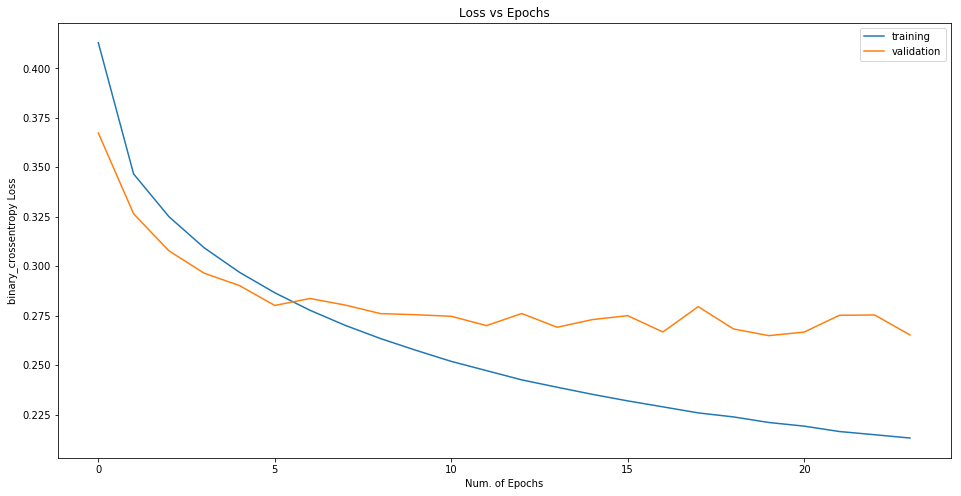

In [42]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 16, 8
plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('Num. of Epochs')
plt.ylabel('binary_crossentropy Loss')
plt.title('Loss vs Epochs')
plt.legend()